# A Cognitive Model or Harmonic Types

In [1]:
# %env ROCM_PATH=/opt/rocm
# %env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env HSA_OVERRIDE_GFX_VERSION=""

env: HSA_OVERRIDE_GFX_VERSION=""


In [2]:
import jax
import jax.numpy as jnp
print(jax.devices())

import numpyro
from numpyro.distributions import *
#from collections import Counter
import numpyro.infer
#import numpyro.optim
#import numpyro.util
numpyro.enable_validation(True)


import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

2024-01-25 23:45:29.773539: E external/xla/xla/stream_executor/plugin_registry.cc:90] Invalid plugin kind specified: DNN
2024-01-25 23:45:29.987679: E external/xla/xla/stream_executor/rocm/rocm_driver.cc:261] failed call to hipInit: HIP_ERROR_InvalidDevice


[CpuDevice(id=0)]


/home/chfin/Uni/phd/code/harmony-ornamentation-test/env-amd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_30154/4141021329.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# gpu = True and torch.cuda.is_available()

# # TODO: set the GPU you want to use
# gpu_n = 0

# torch.set_default_dtype(torch.float64)
# #torch.set_default_dtype(torch.float32)

# device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
# torch.set_default_device(device)
# print(device)
jax.devices()

[CpuDevice(id=0)]

In [4]:
# def save_rng_state(name):
#     fn = name + '-' + datetime.today().isoformat() + '.state'
#     state = pyro.util.get_rng_state()
#     with open('rng-' + fn, 'w') as f:
#         print(state, file=f)
#     torch.save(state['torch'], 'torch-' + fn)

In [5]:
# # set random seeds
# pyro.set_rng_seed(0)
# #torch.set_deterministic(True)
# #torch.set_num_threads(1)
# #torch.set_num_interop_threads(1)
rng = jax.random.PRNGKey(0)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# 1. Experimental Setup

## Model

A chord consists of a number of notes,
which are either generated as stable chord tones or as ornaments.
We model this process by distinguishing (for each chord type)
a distribution of chord tones and a distribution of ornaments.
For each generated note, a coin is flipped as to whether the tone is generated as a chord tone or ornament.
The pitch is then drawn from the corresponding distribution.
Since we don't always know the type of a note, we flip another coin to decide whether the type is observed or not (in which case `unknown` is emitted for both ornaments and chordtones).

Priors:
- choose $\vec\chi \sim \text{Dirichlet}(0.5, n_\text{harmonies})$
- choose $\lambda \sim \text{Gamma}(3,1)$
- for each chord type $c$:
  - choose $\theta_c \sim \text{Beta}(1,1)$
  - choose $\vec\phi_{ct}^{(c)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$
  - choose $\vec\phi_{or}^{(c)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$

Generating a single chord (long version):
- choose $h \sim \text{Categorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- for each note $i \in 1, \ldots, n$:
  - choose $t_i \sim \text{Bernoulli}(\theta_h)$
  - choose $p_i \sim \begin{cases}
                       \text{Categorical}(\vec\phi_{ct}^{(h)}) & \text{if } t_i = 1\\
                       \text{Categorical}(\vec\phi_{or}^{(h)}) & \text{if } t_i = 0
                     \end{cases}$
  - choose $o_i \sim \text{Bernoulli}(p_\text{obs})$
  - choose $ot_i = \begin{cases}
                     \text{'chordtone'} & \text{if } o_i = 1 \wedge p_i = 1\\
                     \text{'ornament'} & \text{if } o_i = 1 \wedge p_i = 0\\
                     \text{'unknown'} & \text{if } o_i = 0\\
                   \end{cases}$
- count $(p_i,ot_i)$ pairs

Generating a single chord (compact version)
- choose $h \sim \text{Catecorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- choose $n_{p,ot} \sim \text{Multinomial}(n, \vec\nu),$ where
  - $\nu_{ct} = p_\text{obs} \cdot \theta \cdot \vec\phi_{ct}^{(h)}$
  - $\nu_{or} = p_\text{obs} \cdot (1-\theta) \cdot \vec\phi_{or}^{(o)}$
  - $\nu_{uk} = (1-p_\text{obs}) \cdot \left( \theta \vec\phi_{ct}^{(h)} + (1-\theta) \vec\phi_{or}^{(h)} \right)$
  - $\nu = \text{concat}(\nu_{ct}, \nu_{or}, \nu_{uk})$

In [22]:
def chord_model(npcs, nharmonies, data, subsamples=500, pobserve=0.5, **kwargs):    
    # parameters priors:
    # distribution of the harmonies
    p_harmony = numpyro.sample('p_harmony', Dirichlet(0.5 * jnp.ones(nharmonies)))
    # distribution of notes in the harmonies
    with numpyro.plate('harmonies', nharmonies) as ind:
        # distribution of ornament probability
        p_is_chordtone = numpyro.sample('p_is_chordtone', Beta(jnp.ones(nharmonies), jnp.ones(nharmonies)))
        #print(p_is_chordtone.shape)
        # distribution of notes per note type
        p_chordtones = numpyro.sample('p_chordtones', Dirichlet(0.5 * jnp.ones(npcs)))
        p_ornaments  = numpyro.sample('p_ornaments', Dirichlet(0.5 * jnp.ones(npcs)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        #p_ct = p_is_chordtone       * p_chordtones
        #p_or = (1 - p_is_chordtone) * p_ornaments
        p_ct = jnp.matmul(jnp.diag(p_is_chordtone), p_chordtones)
        p_or = jnp.matmul(jnp.diag(1 - p_is_chordtone), p_ornaments)
        p_unobserved = p_ct + p_or
        p_tones = jnp.concatenate([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], axis=1)
    # distribution of note rate in chords
    rate_notes = numpyro.sample('rate_notes', Gamma(3, 1))
    
    # sampling the data:
    nchords = len(data['c'])
    subs = min(nchords, subsamples) if subsamples != None else None
    with numpyro.plate('data', nchords, subsample_size=subs) as ind:
        # pick a harmony
        c = numpyro.sample('c', Categorical(p_harmony), obs=data['c'][ind])
        # pick a number of notes
        nnotes = 1 + numpyro.sample('n', Poisson(rate_notes), obs=data['n'][ind])
        # sample chordtones
        # Normally we would sample nnotes notes for each chord, but that doesn't work vectorized.
        # However, evaluating the probability ignores n, so we can just provide 1 here.
        notes = numpyro.sample('chord', Multinomial(1, p_tones[c], validate_args=False), obs=data['notes'][ind])
        chords = {'c': c,
                  'n': nnotes,
                  'counts': notes.reshape(-1,npcs)}
    return chords

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [7]:
def chord_guide(npcs, nharmonies, data, subsamples=500, pobserve=0.5):
    # posterior of p_harmony
    params_p_harmony = numpyro.param('params_p_harmony',
                                     0.5 * jnp.ones(nharmonies),
                                     constraint=constraints.positive)
    numpyro.sample('p_harmony', Dirichlet(params_p_harmony))
    
    # posteriors of notes dists in harmonies (parameters)
    params_p_chordtones = numpyro.param('params_p_chordtones',
                                        0.5 * jnp.ones(npcs),
                                        constraint=constraints.positive)
    params_p_ornaments = numpyro.param('params_p_ornaments',
                                       0.5 * jnp.ones(npcs),
                                       constraint=constraints.positive)
    
    # posterior of ornament probability (parameters)
    alpha_p_ict = numpyro.param('alpha_p_ict',
                                jnp.ones(nharmonies),
                                constraint=constraints.positive)
    beta_p_ict = numpyro.param('beta_p_ict',
                               jnp.ones(nharmonies),
                               constraint=constraints.positive)
    
    # posteriors of ornament probability and note distributions
    with numpyro.plate('harmonies', nharmonies) as ind:
        numpyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))
        numpyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        numpyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
        
    #posterior of note rate
    alpha_rate_notes = numpyro.param('alpha_rate_notes', 3,
                                  constraint=constraints.positive)
    beta_rate_notes = numpyro.param('beta_rate_notes',
                                 1,
                                 constraint=constraints.positive)
    rate_notes = numpyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))

## Data and Conditioning

### Data Format

The input data (i.e. the observations that the model is conditioned on) is represented by three tensors:
- `c` for the chord labels (as "categorical" integers)
- `n` for the number of notes in each chord
- `notes` for the observed notes in each chord

Each of these tensors represents the values for all chords at the same time (i.e. a *vectorized* representation),
so the first dimension of each equals `nchords`, the number of chords.
`c` and `n` are vectors, i.e. their value for each chord is a scalar.
`notes` represents a vector for each chord that contains the counts of all pitch $\times$ note type pairs in the chord.
If we assume 29 pitch classes, we therefore have 87 entries: 29 for the chordtones, 29 for the ornaments, and 29 for the notes of unknown type.
As a result, `notes` has dimension `nchords` $\times$ 87.

The values of `c` represent each chord's type, which is distributed according to a categorical distribution.
In pyro/torch, categories are represented as integers, so we must convert textual labels into integers.
Similarly, the index of a note in `notes` is determined by it's pitch class and type (as outlined above).
While we allow negative pitch classes, they can be easily transformed into indices (and *vice versa*) by shifting all values by `npcs // 2`.

In [8]:
def chord_tensor(notes):
    """Takes a list of notes as (fifth, type) pairs and returns a vector of counts."""
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = np.zeros((3, npcs))
    for (fifth, t) in notes:
        chord[notetype[t], utils.fifth_to_index(fifth)] += 1
    return chord

def annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["notes"] = jnp.concatenate([chord_tensor(c['notes']).reshape((1,-1)) for c in chords], axis=0)
    obs["c"] = jnp.array([c['label'] for c in chords])
    obs["n"] = jnp.array([len(c['notes']) - 1. for c in chords])
    return obs

### Loading the Dataset

The data is loaded from a TSV file that.
The resulting dataframe is converted to the observation format that we pass to the model.

In [9]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...") 
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    #floatsize = 8 * jnp.get_default_dtype().itemsize
    # check if precomputed tensor data is available:
    prefn = f"{filename}_precomp.npz"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = jnp.load(prefn)
    else:
        print('extracting chords...')
        chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
                  for (_, label), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = annot_data_obs(chords)
        jnp.savez(prefn, **obs)
    
    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

It is important to initialize the posterior parameters with good guesses, close to their final values.
This function estimates the final values by ignoring unknown note types:

In [34]:
def get_init_params(df, nharms, npcs):
    init = dict()
    
    init['params_p_harmony'] = jnp.array(df.groupby('numlabel').size().sort_values(ascending=False)) + 0.5

    params_p_chordtones = np.full((nharms, npcs), 0.5)
    jnp.zeros([nharms,npcs]) + 0.5
    for (numlabel, fifth), grp in df[df.type=='chordtone'].groupby(['numlabel','fifth']):
        params_p_chordtones[numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()
    init['params_p_chordtones'] = jnp.array(params_p_chordtones)

    params_p_ornaments = np.full((nharms,npcs), 0.5)
    for (numlabel, fifth), grp in df[df.type=='ornament'].groupby(['numlabel','fifth']):
        params_p_ornaments[numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()
    init['params_p_ornaments'] = jnp.array(params_p_ornaments)
    
    init['alpha_p_ict'] = jnp.array([sum(df[df.numlabel==l].type=='chordtone') for l in range(nharms)]) + 1.
    init['beta_p_ict'] = jnp.array([sum(df[df.numlabel==l].type=='ornament') for l in range(nharms)]) + 1.
    
    chord_sizes = df.groupby('chordid').size()-1
    init['alpha_rate_notes'] = sum(chord_sizes) + 3.
    init['beta_rate_notes'] = len(chord_sizes) + 1.
    return init

After inferring the parameters we save them for easier inspection and reuse.

In [30]:
def save_params(params, chordtypes, name):
    jnp.savez(path.join("results", name+'.npy'), **params)
    with open(path.join("results", name+'.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key,val in params.items()},
                   'chordtypes': chordtypes},
                  f)

## Inference

Inference of the posterior is done via variational inference, i.e. by optimizing the parameters of the guide.
The function `infer_posteriors` takes a dataset of observations,
performs the optimization, and returns the optimized parameters together with some of their histories.

In [28]:
def infer_posteriors(obs, init, chordtypes,
                     nsteps=5_000, subsamples=10_000, particles=1,
                     plot_loss=True, save_as=None):
    # optimize the parameters of the guide
    # rng = jax.random.PRNGKey(1625) # set every time for independent reproducibility
    svi = numpyro.infer.SVI(model=chord_model,
                           guide=chord_guide,
                           optim=numpyro.optim.Adam(step_size=0.01),
                           loss=numpyro.infer.Trace_ELBO(num_particles=particles))
    nharms = len(chordtypes)
    
    # set up histories for the loss and some of the parameters
    losses = np.zeros(nsteps)
    param_history = {name:np.zeros(nsteps) for name in ['alpha_rate_notes', 'beta_rate_notes']}#, 'alpha_p_ict', 'beta_p_ict']}
    root_history = np.zeros((nsteps,nharms))
    harm_history = np.zeros((nsteps,nharms))

    # run the optimization
    svi_state = svi.init(rng, npcs, nharms, obs, subsamples, init_params=init)
    for i in tqdm.trange(nsteps):
        # update parameters and record loss
        svi_state, losses[i] = svi.update(svi_state, npcs, nharms, obs, subsamples)
        #losses[i] = loss
        
        # record values of some parameters
        params = svi.get_params(svi_state)
        root_history[i] = np.array(params['params_p_chordtones'][:,fifth_range])
        harm_history[i] = np.array(params['params_p_harmony'])
        for (name, value) in params.items():
            if name in param_history:
                param_history[name][i] = np.array(value)

    # plot the loss
    if plot_loss:
        plt.figure()
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title(f"loss ({save_as})")
        plt.show(block=False)
        print("loss variance (last 100 steps):", losses[-100:].var())
    
    if save_as != None:
        save_params(svi.get_params(svi_state), chordtypes, save_as)
    
    return params, param_history, root_history, harm_history

## Plotting

To inspect the results and the behaviour of the optimization, we define some functions for plotting parameter histories and posterior distributions.

In [13]:
# histories

# several parameters
def plot_params_history(name, ax, history):
    df = pd.DataFrame(history)
    df.plot(ax=ax)
    ax.set_title(f"history ({name})")
    ax.set_xlabel("iteration")
    
# single parameter
def plot_param_history(name, ax, root_history, ylabel):
    ax.plot(root_history)
    ax.set_xlabel("iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} ({name})")

# all parameters
def plot_histories(name, param_history, root_history, harm_history):
    fig, ax = plt.subplots(1,3, figsize=(9,3))
    plot_params_history(name, ax[0], param_history)
    plot_param_history(name, ax[1], root_history, 'root parameters')
    plot_param_history(name, ax[2], harm_history, 'chord-type parameters')
    fig.tight_layout()
    plt.show(block=False)

In [14]:
# posteriors

# posterior of 'rate_notes'
def plot_note_rate(name, ax1, ax2, params, lower=0, upper=10):
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))
    
    alpha = params['alpha_rate_notes']
    beta = params['beta_rate_notes']
    x = np.linspace(lower, upper, 200)
    y = stats.gamma.pdf(x, alpha, scale=1/beta)
    ax1.plot(x,y)
    ax1.set_xlabel('rate_notes')
    ax1.set_title(f'note rate distribution ({name})')
    
    xrate = jnp.linspace(0,15,16)
    yrate = stats.nbinom.pmf(xrate, alpha, 1/(1+1/beta))
    ax2.bar(xrate+1, yrate)
    ax2.set_xlabel('nnotes')
    ax2.set_title(f'expected notes per chord distribution ({name})')
    
    #fig.tight_layout()
    #plt.show(block=False)
    
def plot_note_rates(name, phist, n=100, lower=0, upper=10):
    alphas = phist['alpha_rate_notes'][-n:]
    betas = phist['beta_rate_notes'][-n:]
    x = np.linspace(lower, upper, 200)
    ys = np.array([stats.gamma.pdf(x, a, scale=1/b) for (a,b) in zip(alphas,betas)]).transpose()
    plt.plot(x,ys, color='steelblue', alpha=0.5)
    plt.xlabel(f'rate_notes (last {n} iterations)')
    plt.title(f'note rate history ({name})')
    plt.show(block=False)
    
# posterior of 'p_is_chordtone'
def plot_p_ict(name, ax, params, harmtypes, lower=0, upper=1):
    #plt.figure(figsize=(9,3))
    alphas = params["alpha_p_ict"]
    betas  = params["beta_p_ict"]
    x = jnp.linspace(lower, upper, 200)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
    ax.plot(x,y)
    ax.set_xlabel("p_is_chordtone")
    ax.legend(harmtypes, bbox_to_anchor=(0.5,1.1), loc='lower center', ncols=4)
    ax.set_title(f"posteriors of 'p_is_chordtone' ({name})")
    #plt.show(block=False)

# posterior of chord type probabilities
def plot_chord_type_dist(name, ax, params, labels):
    #plt.figure(figsize=(6,6))
    alphas = params['params_p_harmony']
    ax.barh(np.arange(len(alphas)), alphas, tick_label=labels)
    ax.invert_yaxis()
    ax.set_xlabel("params_p_harmony")
    ax.set_title(f'chord-type distribution ({name})')
    #plt.show(block=False)

# posteriors of note probabilities
def plot_chords(name, params, labels):
    post_chordtones = params['params_p_chordtones']
    post_ornaments = params['params_p_ornaments']
    for i, label in enumerate(labels):
        utils.plot_profile(post_chordtones[i], post_ornaments[i], f"{label} ({name})")
        utils.play_chord(post_chordtones[i])

# plot all posteriors
def plot_posteriors(name, params, chordtypes, rate_range=(0,10), ict_range=(0,1)):
    fig = plt.figure(constrained_layout=True, figsize=(9,12))
    axs = fig.subplot_mosaic([
            ["rate", "types"],
            ["nnotes", "types"],
            ["ict", "ict"]])
    
    plot_note_rate(name, axs['rate'], axs['nnotes'], params, lower=rate_range[0], upper=rate_range[1])
    plot_chord_type_dist(name, axs['types'], params, chordtypes)
    plot_p_ict(name, axs['ict'], params, chordtypes, lower=ict_range[0], upper=ict_range[1])
    
    fig.tight_layout()
    plt.show(block=False)

# 2. Experiments

## DCML Corpus

The DCML corpus is a collection of classical pieces with elaborate harmonic annotations.
Here we only distinguish the basic harmonic types defined in the annotation standard (triads and seventh chords),
since the extra information (inversion, suspensions, added notes etc.) do not change the type of the chord.

In [35]:
# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


In [36]:
dcml_df

,chordid,label,fifth,type,numlabel
0,0,M,0,chordtone,0
1,0,M,0,chordtone,0
2,0,M,0,chordtone,0
3,0,M,0,chordtone,0
4,0,M,2,ornament,0
...,...,...,...,...,...
864604,113770,M,4,chordtone,0
864605,113770,M,1,chordtone,0
864606,113770,M,0,chordtone,0
864607,113770,M,4,chordtone,0


In [37]:
len(dcml_df.chordid.unique())

113771

In [38]:
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    "mM7": "minor-major-7th",
    "+7": "augmented-7th",
}
len(dcml_df[dcml_df.label.map(lambda l: l in dcml_chordtype_map)].chordid.unique())

112813

100%|██████████████████████████████████████████████████████████████████| 350/350 [01:51<00:00,  3.14it/s]


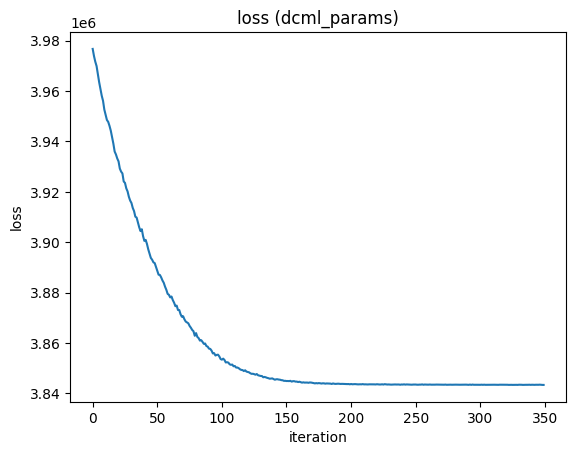

loss variance (last 100 steps): 1373.2019750000002


In [39]:
# run the optimization
dcml_params, dhist, droots, dharm = infer_posteriors(dcml_obs, dcml_init, dcml_chordtypes,
                                                     nsteps=350, subsamples=None, particles=1,
                                                     save_as="dcml_params")

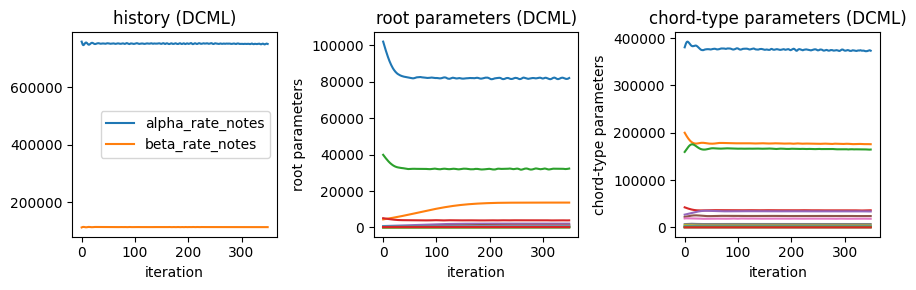

In [40]:
# plot the histories the parameters to check convergence
plot_histories("DCML", dhist, droots, dharm)

/tmp/ipykernel_30154/508476899.py:77: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


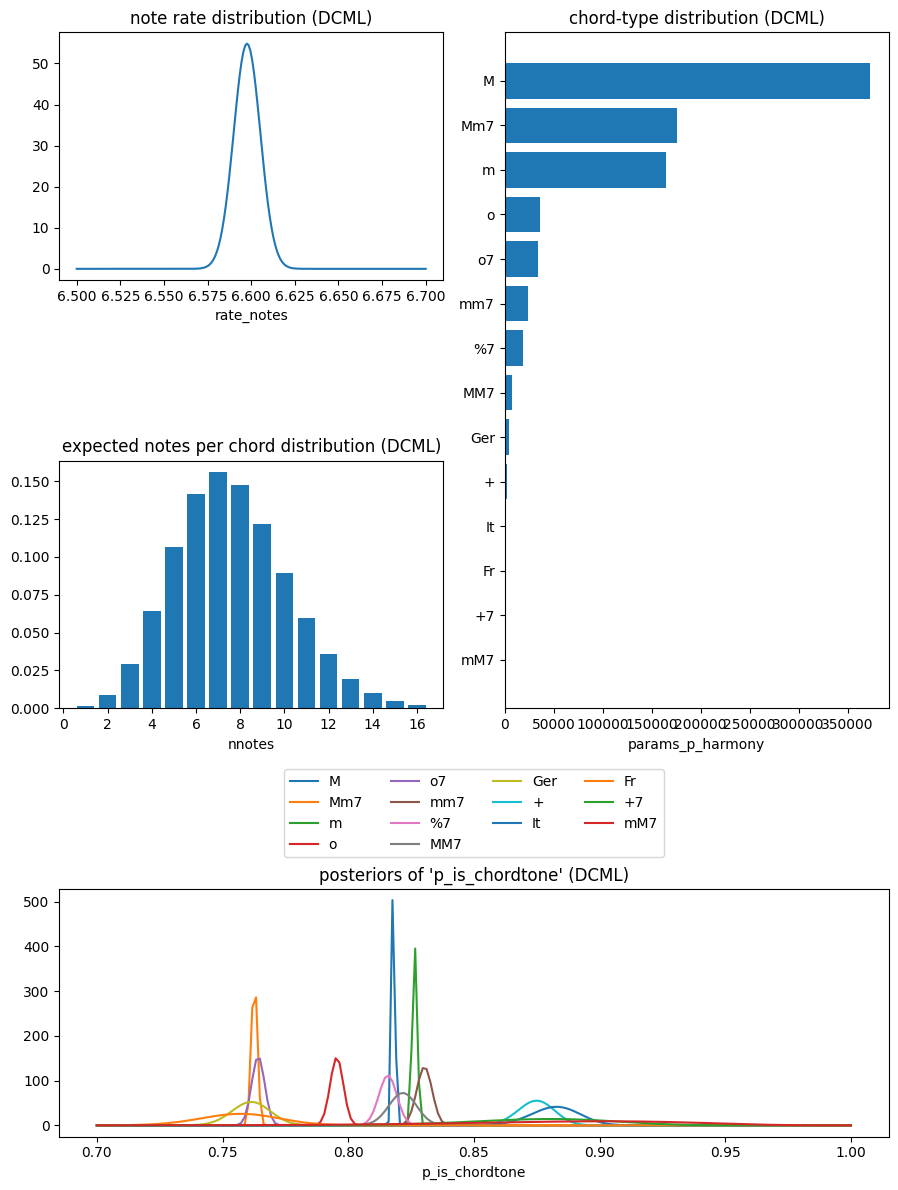

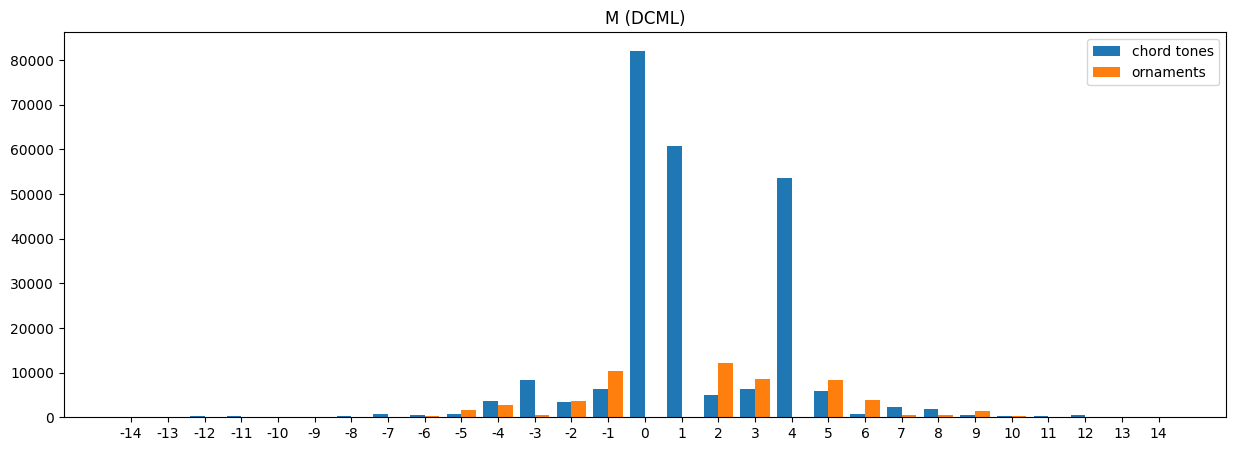

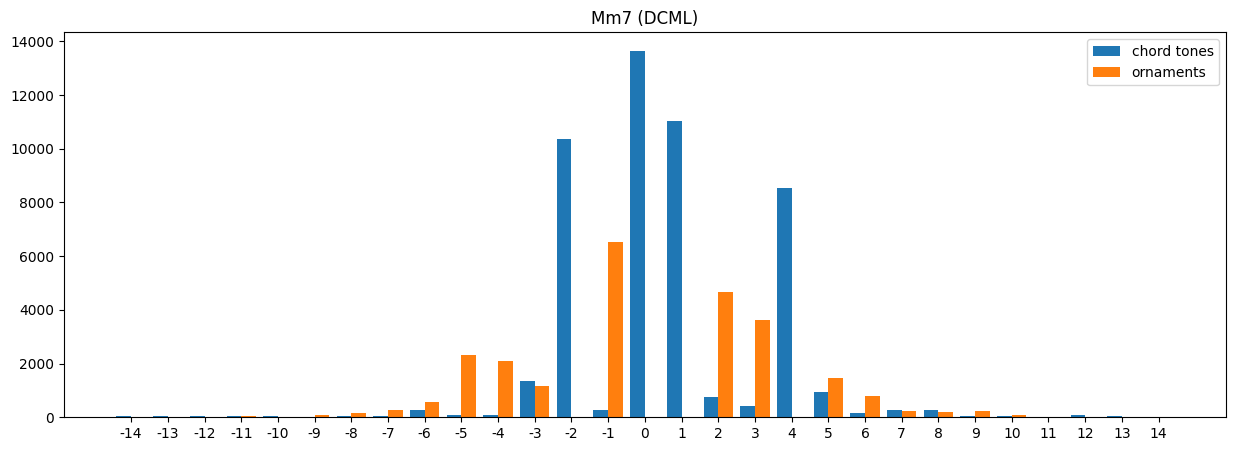

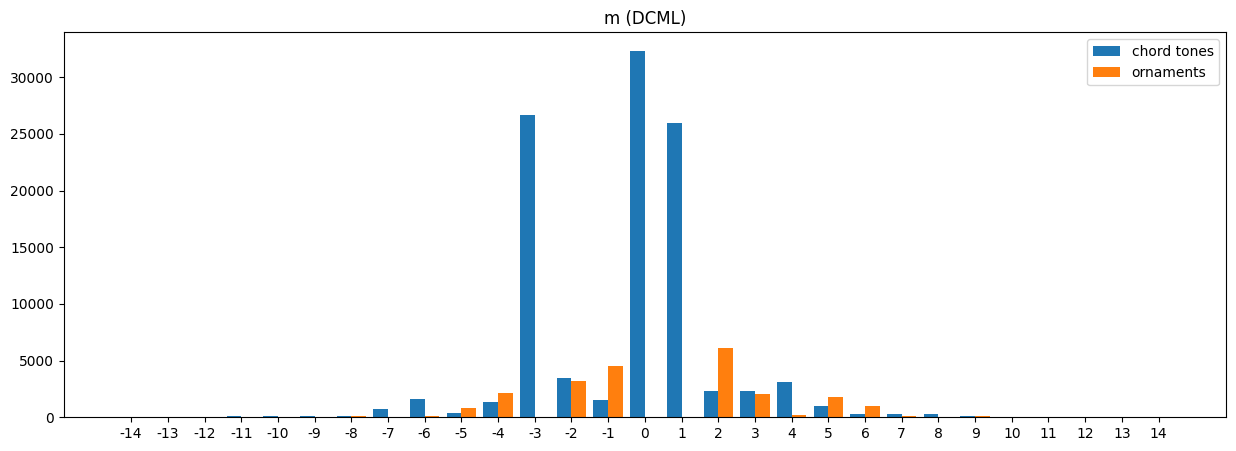

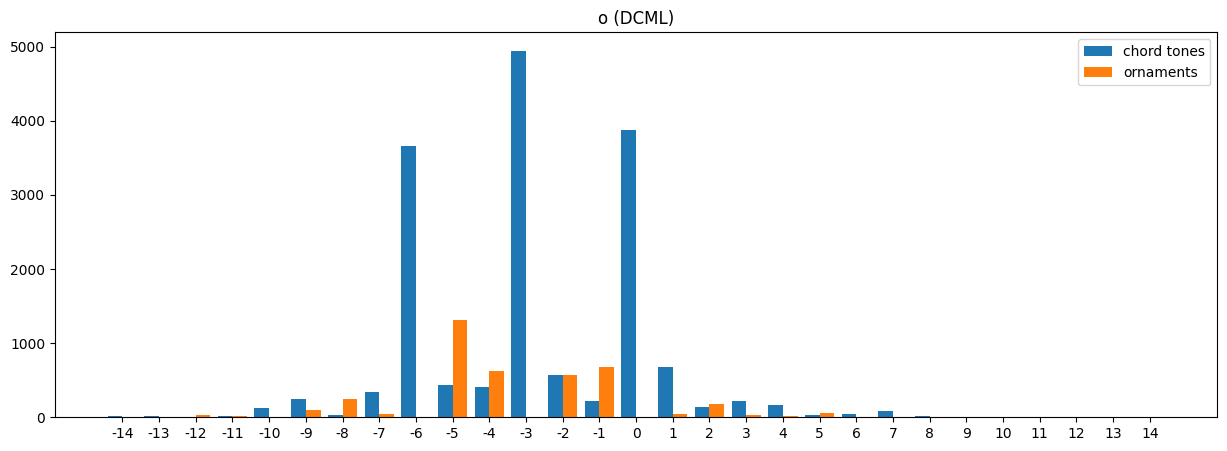

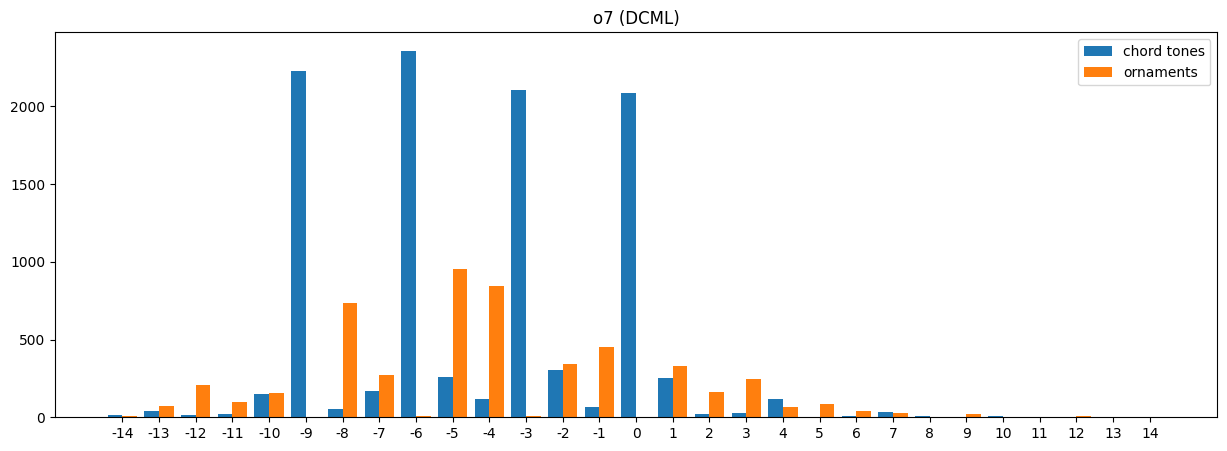

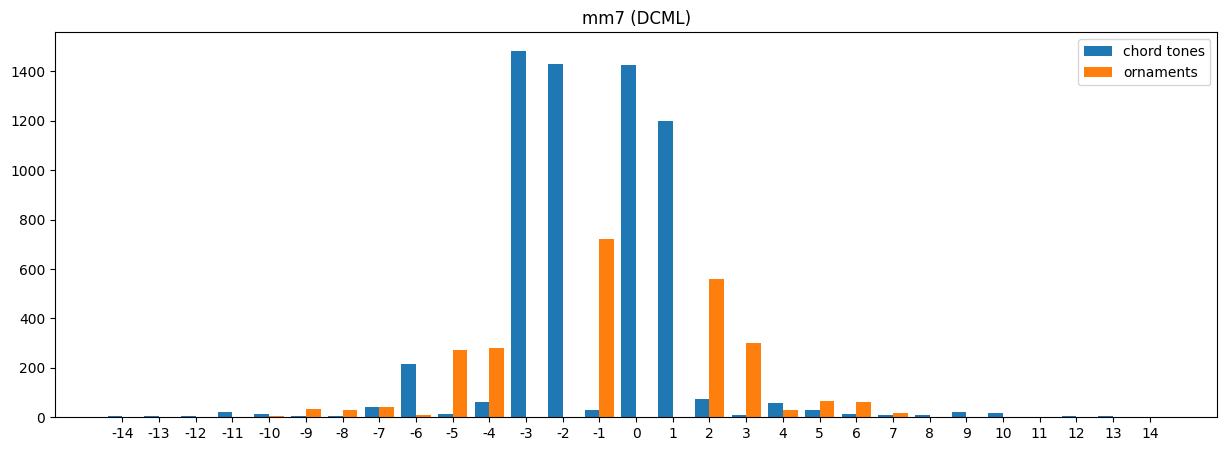

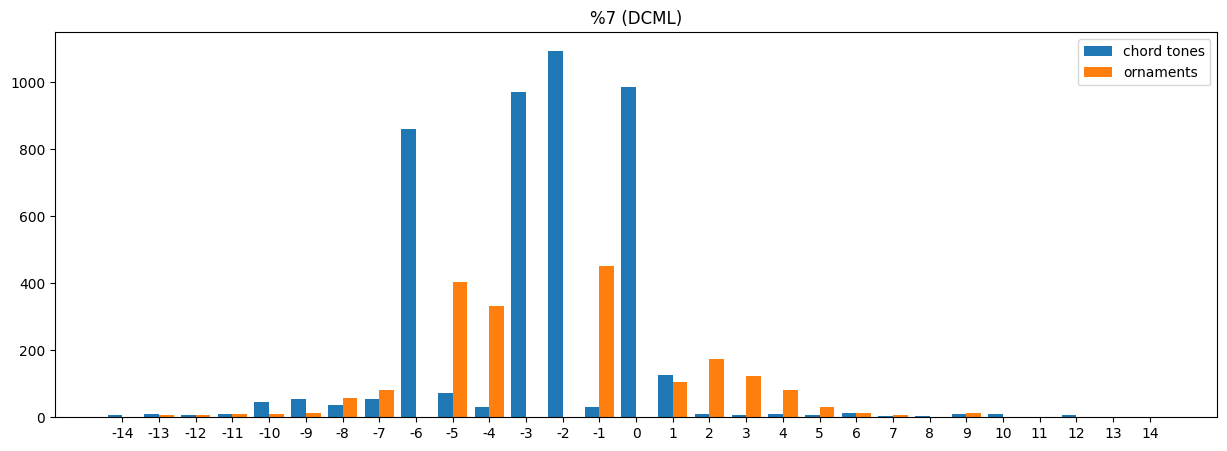

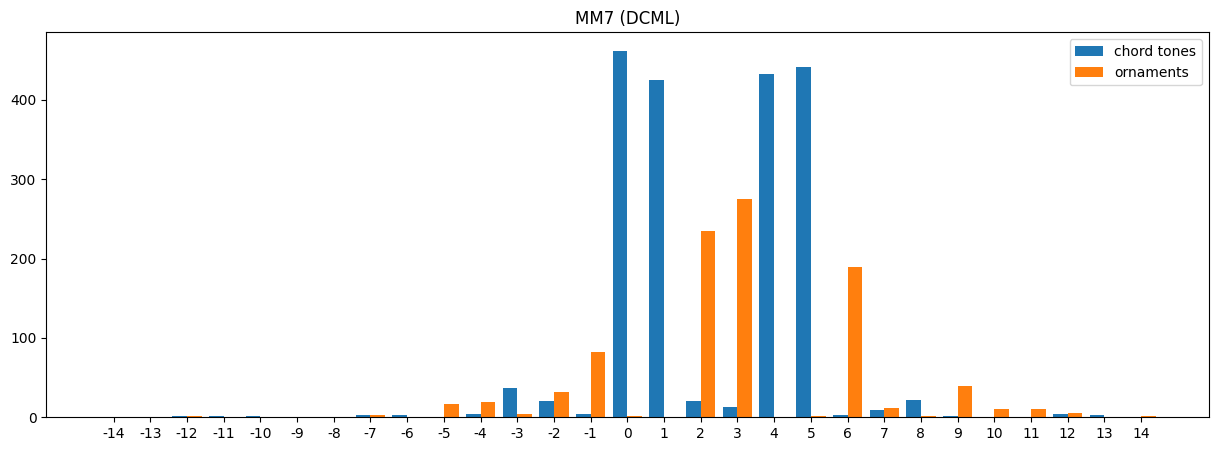

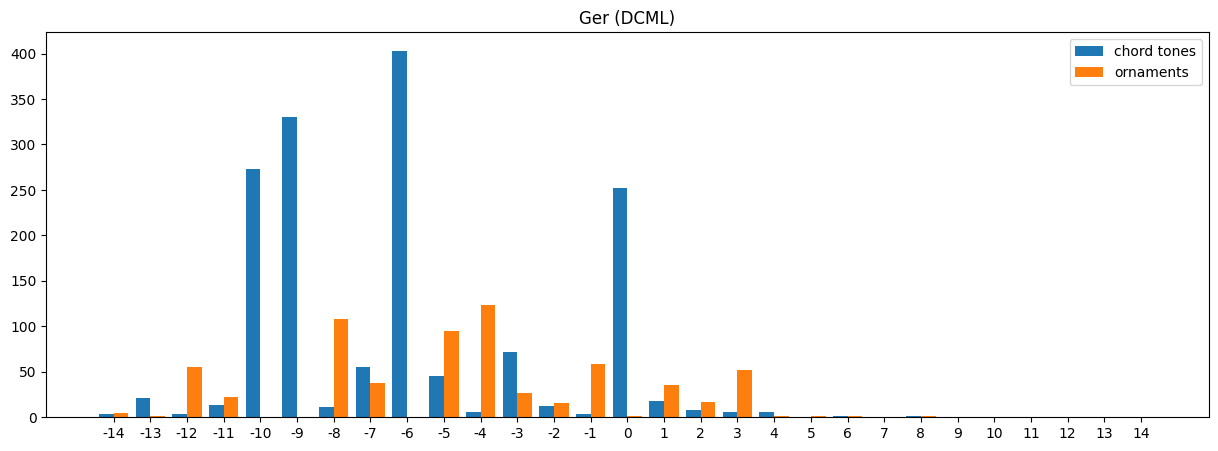

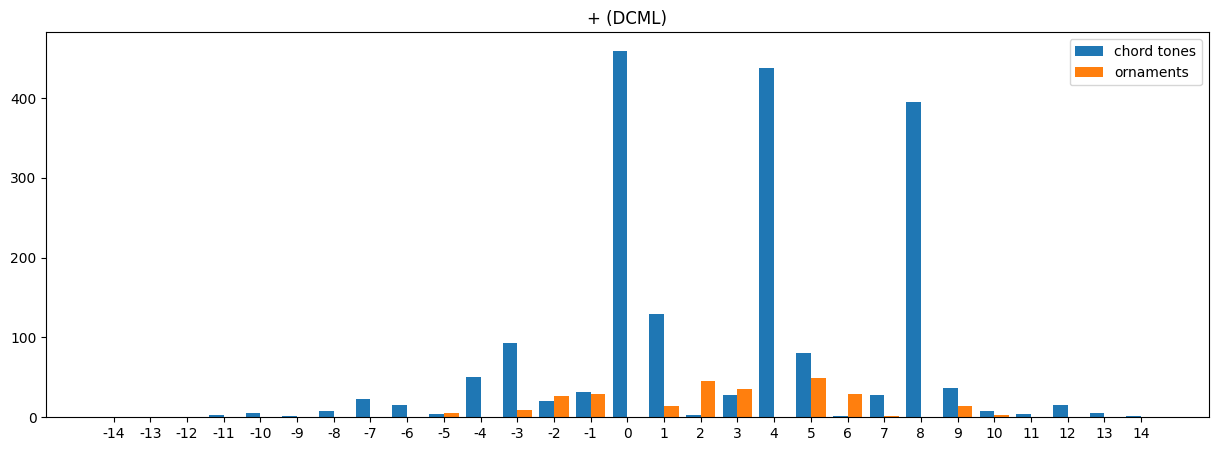

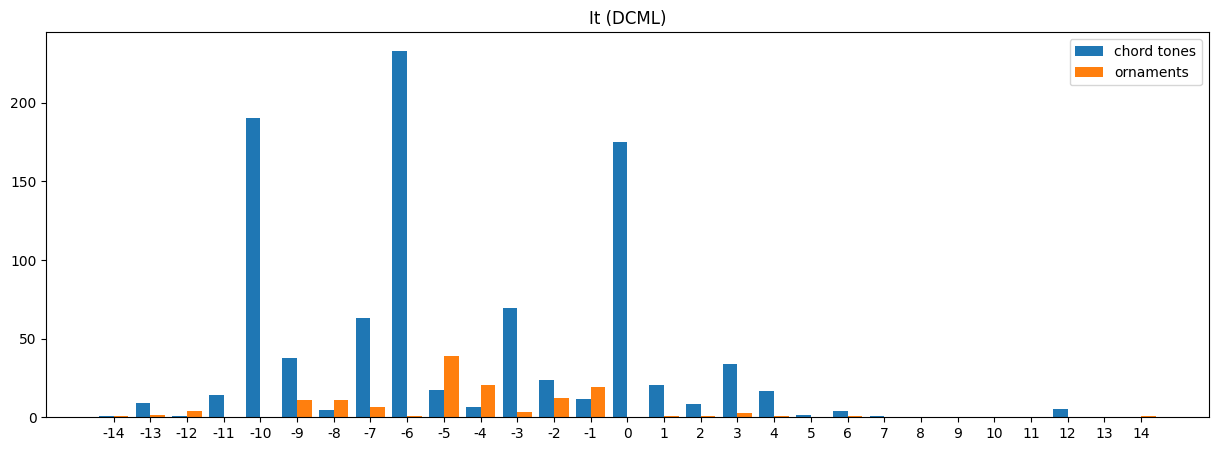

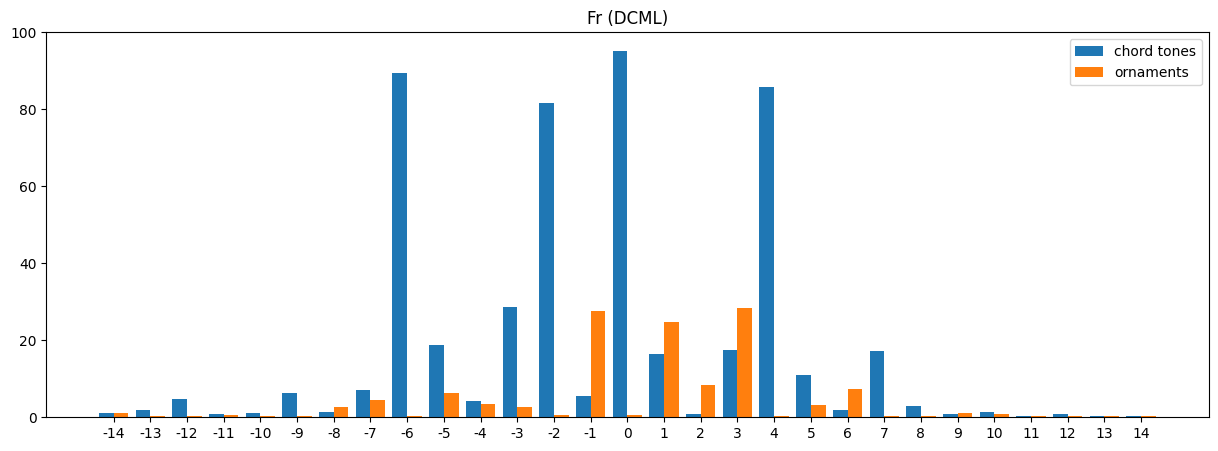

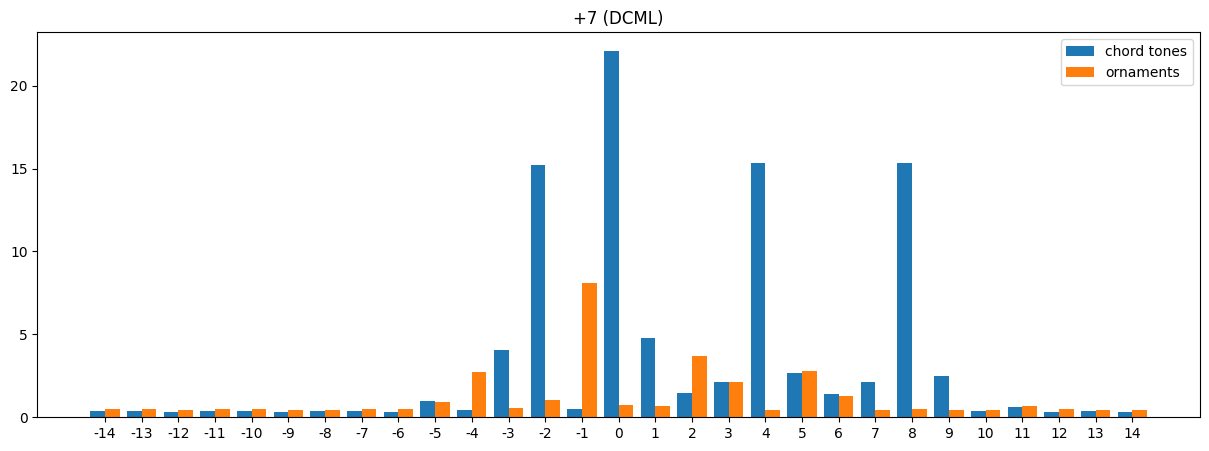

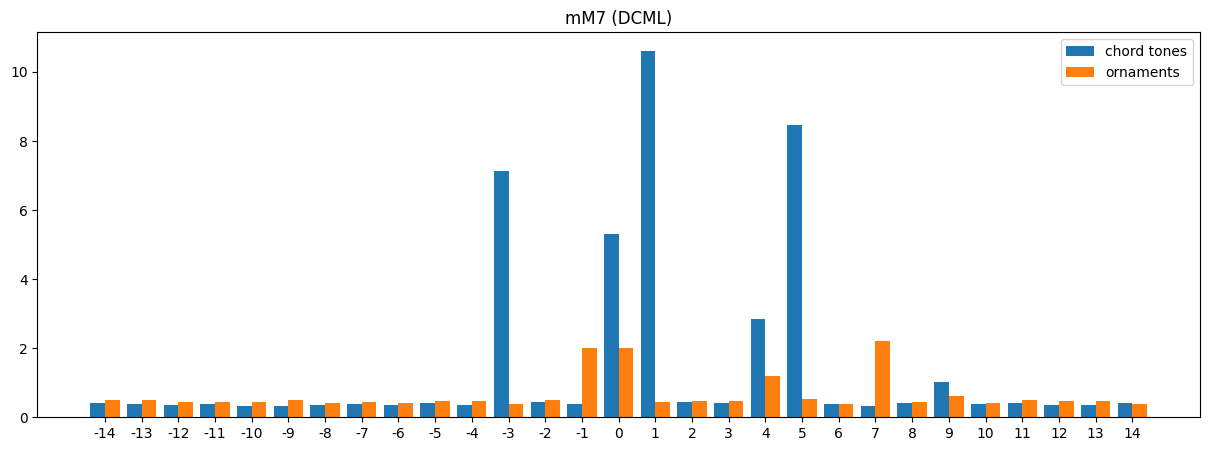

In [41]:
# plot the posterior distributions of the parameters
plot_posteriors("DCML", dcml_params, dcml_chordtypes, rate_range=(6.5,6.7), ict_range=(0.7,1))
plot_chords("DCML", dcml_params, dcml_chordtypes)

## EWLD

EWLD is a large subset of Wikifonia, so it shares the same format.

In [ ]:
# prepare the dataset
ewld_df, ewld_obs, ewld_chordtypes = load_dataset('ewld.tsv')
ewld_init = get_init_params(ewld_df, len(ewld_chordtypes), npcs)
ewld_init['harmonies'].int()

In [ ]:
# run the optimization
ewld_params, ehist, eroots, eharm = infer_posteriors(ewld_obs, ewld_init, ewld_chordtypes,
                                                     nsteps=350, subsamples=None, particles=1,
                                                     save_as="ewld_params")

In [ ]:
# plot the histories the parameters to check convergence
plot_histories("EWLD", ehist, eroots, eharm)

In [ ]:
# plot the posterior distributions of the parameters
plot_posteriors("EWLD", ewld_params, ewld_chordtypes, rate_range=(2.3,2.35), ict_range=(0.5,0.95))
plot_chords("EWLD", ewld_params, ewld_chordtypes)

In [ ]:
# for script mode
plt.show()